In [1]:
from IPython.display import HTML
HTML('''<style>.CodeMirror{min-width:100% !important;}</style>''')

In [2]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [3]:
pylab.rcParams['figure.figsize'] = (6,4)

In [4]:
data_dir = '/global/homes/n/nhand/nbodykit-0.2/data/'

![nbodykit](nbodykit-logo.png)

### <center>a massively parallel large-scale structure toolkit</center>
<br/>
##### <center>Nick Hand and Yu Feng</center>

# the goal:

an open-source, unified python package supporting a variety of the most widely-used algorithms in large-scale structure 

# some motivations

* a unified treatment of simulation and observational datasets by insulating algorithms from data containers
* take advantage of reducing wall-clock time by scaling to thousands of cores
* deployment and availability on large, super computing facilities

# and some lessons learned

* minimize code complexity
* no more parameter files!
* use the interactive nature of Python -- execute simple, parallelized user-written scripts
* better interface with IPython, easier help, etc

# An interactive "lab" framework

In [5]:
from nbodykit.lab import *
from nbodykit import setup_logging

setup_logging()

# Input data: the `Source` module


Two ways of generating input data:
* reading from disk
* generating on the fly, i.e., "simulations"

Two forms of input data:
* the typical catalog of discrete objects $\rightarrow$ `ParticleSource`
* a density field stored on a mesh grid $\rightarrow$ `MeshSource`

# Reading `ParticleSource` data from disk

* the relevant class is `Source.File`
* built upon an `IO` module that has several file formats built-in:
   * `IO.CSVFile`, `IO.BinaryFile`, `IO.HDFFile`, `IO.BigFile`, `IO.TPMBinaryFile`
* can also implement your own file format

In [148]:
Source.File?

In [6]:
# read 4 dark matter binary snapshots at z = 1
f = Source.File(IO.TPMBinaryFile, path=data_dir+'tpmsph_0.5000.bin*')

print("columns: ", f.columns)
print("total size: ", f.csize)
print("size on this rank: ", f.size)

[ 000008.26 ]   0:fb89848c8ac0 01-25 20:39  ParticleSource  INFO     Extra arguments to FileType: {}
[ 000008.26 ]   0:fb89848c8ac0 01-25 20:39  ParticleSource  INFO     total number of particles = 538540857


columns:  ['ID', 'Position', 'Selection', 'Velocity', 'Weight']
total size:  538540857
size on this rank:  538540857


In [7]:
# read CSV QSO catalog
names = ['ra', 'dec', 'z', 'nbar', 'weight_fkp', 'weight', 'weight_sys']
path = data_dir+'eboss-qso.data.ascii'
f = Source.File(IO.CSVFile, path, args={'names':names})

print("columns: ", f.columns)
print("total size: ", f.csize)
print("size on this rank: ", f.size)

[ 000148.96 ]   0:fb89848c8ac0 01-25 20:42  ParticleSource  INFO     Extra arguments to FileType: {'names': ['ra', 'dec', 'z', 'nbar', 'weight_fkp', 'weight', 'weight_sys']}
[ 000148.97 ]   0:fb89848c8ac0 01-25 20:42  ParticleSource  INFO     total number of particles = 75121


columns:  ['Selection', 'Weight', 'dec', 'nbar', 'ra', 'weight', 'weight_fkp', 'weight_sys', 'z']
total size:  75121
size on this rank:  75121


# Delayed computation of columns

* don't read data all into memory when initializing a Source
* accessing data columns returns `dask` columns, which are not evaluated until ``compute`` called
* allows easy manipulation of columns in the source

In [8]:
# dict-like cosmology interface to Astropy
cosmo = cosmology.Planck15

# (ra, dec, z) to Cartesian Position
ra, dec, z = f['ra'], f['dec'], f['z']

print("type(ra) = ", type(ra))
print("type(dec) = ", type(dec))
print("type(z) = ", type(z))

f['Position'] = transform.SkyToCartesion(ra, dec, z, cosmo, degrees=True)
print("Position: ", f['Position'])

type(ra) =  <class 'dask.array.core.Array'>
type(dec) =  <class 'dask.array.core.Array'>
type(z) =  <class 'dask.array.core.Array'>
Position:  dask.array<mul-473..., shape=(75121, 3), dtype=float64, chunksize=(75121, 1)>


In [9]:
# add min/max calculations to the dask task graph
pos_min = f['Position'].min(axis=0)
pos_max = f['Position'].max(axis=0)

# finally read the data when compute is called
print("min: ", pos_min.compute())
print("max: ", pos_max.compute())
print("Position: ", f['Position'][-10:].compute())

min:  [-2875.87976759 -2392.83616421  1241.11562782]
max:  [ -360.90080142  2552.85992678  3279.33707993]
Position:  [[-1510.12168011  2016.75855363  2418.54513075]
 [-1621.35407911  2159.2516153   2591.93487717]
 [-1221.67375979  1623.51722263  1943.15072881]
 [-1445.21201274  1907.94889993  2284.35017138]
 [-1617.13336795  2126.06272009  2555.1041812 ]
 [-1376.88783923  1808.06408637  2177.08745985]
 [-1358.23928376  1767.25932587  2134.41559403]
 [ -962.50625084  1248.12433106  1514.06864651]
 [-1299.93890004  1688.42156814  2036.62646232]
 [-1551.13395434  2014.70693762  2438.29077962]]


# "Simulation"-based `ParticleSource`

* biased, lognormal mocks: `Source.LogNormal`
* uniformly-distributed particles: `Source.UniformParticles`

soon: FastPM particles

# Painting: particles to mesh

In [10]:
redshift = 0.613
cosmo = cosmology.Cosmology(Om0=0.307494, H0=67.74, flat=True)

# load the FOF groups
fof = Source.File(IO.HDFFile, data_dir+'fof_0.6250.hdf5')
BoxSize = fof.attrs['BoxSize']

# scale the Position/Velocity
fof['Position'] *= BoxSize
fof['Velocity'] *= BoxSize

# velocity in km/s
H = cosmo.H(redshift).value / cosmo.h
a = 1./(1+redshift)
fof['Velocity'] *= (a*H)

[ 000524.35 ]   0:fb89848c8ac0 01-25 20:48  FileType        INFO     detected single structured array stored as dataset; changing root of HDF file to /FOFGroups
[ 000524.35 ]   0:fb89848c8ac0 01-25 20:48  ParticleSource  INFO     Extra arguments to FileType: {}
[ 000524.35 ]   0:fb89848c8ac0 01-25 20:48  ParticleSource  INFO     total number of particles = 11470861


In [11]:
# convert to a mesh source
mesh = fof.to_mesh(Nmesh=512, window='cic')

# and paint
density = mesh.paint(mode='real')

[ 000549.93 ]   0:fb89848c8ac0 01-25 20:48  ParticleMeshSource INFO     total number of particles = 11470861
[ 000564.85 ]   0:fb89848c8ac0 01-25 20:48  ParticleMeshSource INFO     mean particles per cell is 0.0854646
[ 000564.85 ]   0:fb89848c8ac0 01-25 20:48  ParticleMeshSource INFO     sum is 1.14709e+07 
[ 000564.85 ]   0:fb89848c8ac0 01-25 20:48  ParticleMeshSource INFO     normalized the convention to 1 + delta


<IPython.core.display.Javascript object>


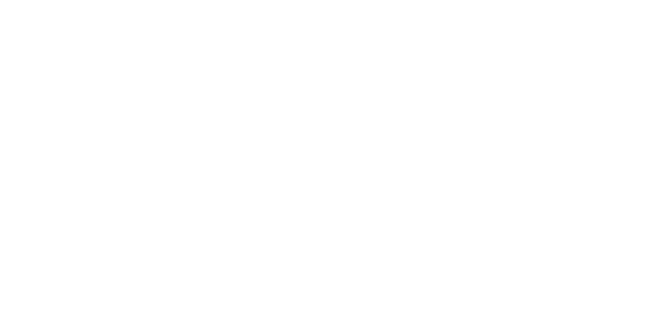

In [12]:
# plot a slice
bounds = [-1380./2, 1380/2., -1380./2, 1380./2]
imshow(density[256], extent=bounds, vmin=-1,vmax=20.0, cmap='viridis')

ax = gca()
ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)
show()

# Mesh sources

* support for saving painted meshes (both in real-space and Fourier-space) to disk using `bigfile`
* loading meshes directly via `Source.BigFileMesh`

In [13]:
# specify a cosmology
cosmo = cosmology.Planck15

# generate linear mesh with given P(k)
Plin = cosmology.EHPower(cosmo, redshift=0.55)
source = Source.LinearMesh(Plin, Nmesh=64, BoxSize=512, seed=42)

# compute P(k) directly from linear grid
r = FFTPower(source, mode='1d', Nmesh=64, dk=0.01, kmin=0.005)

print(r.power)

[ 000683.46 ]   0:fb89848c8ac0 01-25 20:50  FFTPower        INFO     field: LinearMesh(seed=42) painting done


<DataSet: dims: (k_cen: 39), variables: ('k', 'power', 'modes')>


In [14]:
# compute the Gaussian errors
valid = r.power['modes'] > 0
theory = Plin(r.power['k'][valid])
errs = (2*theory**2/r.power['modes'][valid])**0.5

<IPython.core.display.Javascript object>


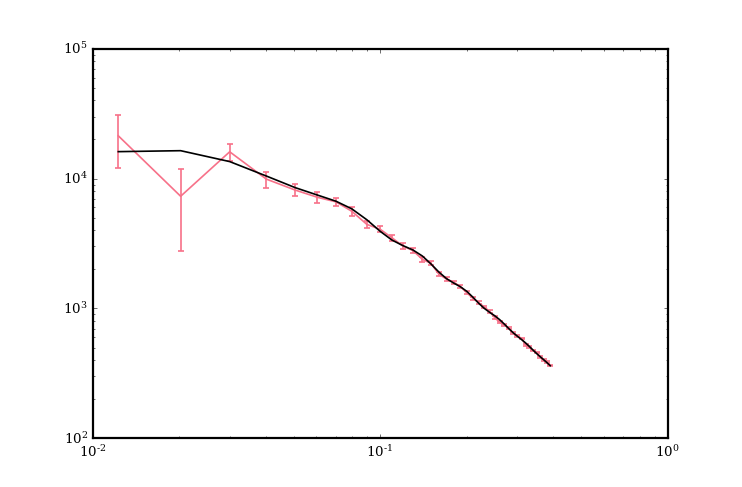

In [16]:
# plot theory and measurment
errorbar(r.power['k'], r.power['power'].real, errs)
loglog(r.power['k'][valid], theory, c='k')

# Populating Halos with a HOD

In [17]:
# add mass to FOF halos
m0 = 2.6106e10
fof['Mass'] = m0*fof['Length']

# construct a full halo Catalog 
halos = Source.HaloCatalog(fof, cosmo=cosmo, redshift=redshift, mdef='vir')
halos['Selection'] = halos['Mass'] > 0

print(halos.columns)

[ 000765.71 ]   0:fb89848c8ac0 01-25 20:52  ParticleSource  INFO     total number of particles = 11470861


['Concentration', 'Mass', 'Position', 'Radius', 'Selection', 'Velocity', 'VelocityOffset', 'Weight']


In [18]:
# convert to format needed by halotools
cat = halos.to_halotools(BoxSize)

# populate halos with an HOD
params = {'logM1':13.9, 'logMmin':13.15}
hod = Source.HOD(cat, seed=42, **params)

[ 000861.31 ]   0:fb89848c8ac0 01-25 20:53  HOD             INFO     satellite fraction: 0.17
[ 000861.37 ]   0:fb89848c8ac0 01-25 20:53  HOD             INFO     mean log10 halo mass: 13.39
[ 000861.38 ]   0:fb89848c8ac0 01-25 20:53  HOD             INFO     std log10 halo mass: 0.42
[ 000861.46 ]   0:fb89848c8ac0 01-25 20:53  HOD             INFO     total number of particles = 979817


In [136]:
print(hod.columns)

['Position', 'Selection', 'Velocity', 'VelocityOffset', 'Weight', 'conc_NFWmodel', 'gal_type', 'halo_id', 'halo_local_id', 'halo_mvir', 'halo_nfw_conc', 'halo_num_centrals', 'halo_num_satellites', 'halo_rvir', 'halo_upid', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_x', 'halo_y', 'halo_z', 'host_centric_distance', 'vx', 'vy', 'vz', 'x', 'y', 'z']


In [19]:
sats = (hod['gal_type'] == 'satellites').compute()
cens = (hod['gal_type'] == 'centrals').compute()

<IPython.core.display.Javascript object>


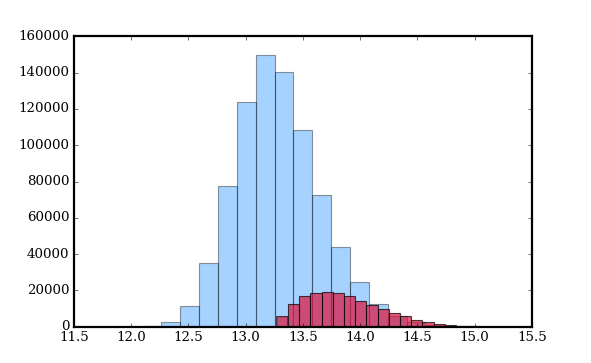

In [20]:
hist(numpy.log10(hod['halo_mvir'][cens]), bins=20, alpha=0.4, facecolor='DodgerBlue')
hist(numpy.log10(hod['halo_mvir'][sats]), bins=20, alpha=0.7, facecolor='Crimson')
show()

In [21]:
hod.repopulate(logMmin=13.0, seed=84)

[ 000945.14 ]   0:fb89848c8ac0 01-25 20:55  HOD             INFO     satellite fraction: 0.12
[ 000945.24 ]   0:fb89848c8ac0 01-25 20:55  HOD             INFO     mean log10 halo mass: 13.25
[ 000945.25 ]   0:fb89848c8ac0 01-25 20:55  HOD             INFO     std log10 halo mass: 0.44
[ 000945.39 ]   0:fb89848c8ac0 01-25 20:55  HOD             INFO     total number of particles = 1372224


In [22]:
# add RSD
hod['Position'] += hod['Velocity']/(a*H) * [0, 0, 1]
hod['Position'] %= BoxSize

In [23]:
# compute P(k,mu) in 5 mu wedges
kws = {'Nmu':5, 'dk':0.005, 'los':[0,0,1]}
r = FFTPower(hod, mode='2d', BoxSize=BoxSize, Nmesh=512, **kws)

[ 000987.79 ]   0:fb89848c8ac0 01-25 20:55  ParticleMeshSource INFO     total number of particles = 1372224
[ 000989.41 ]   0:fb89848c8ac0 01-25 20:56  ParticleMeshSource INFO     mean particles per cell is 0.0102239
[ 000989.41 ]   0:fb89848c8ac0 01-25 20:56  ParticleMeshSource INFO     sum is 1.37222e+06 
[ 000989.41 ]   0:fb89848c8ac0 01-25 20:56  ParticleMeshSource INFO     normalized the convention to 1 + delta
[ 000995.46 ]   0:fb89848c8ac0 01-25 20:56  FFTPower        INFO     field: (<nbodykit.source.particle.hod.HOD object at 0x7f28b6bd2da0> as ParticleMeshSource) painting done


<IPython.core.display.Javascript object>


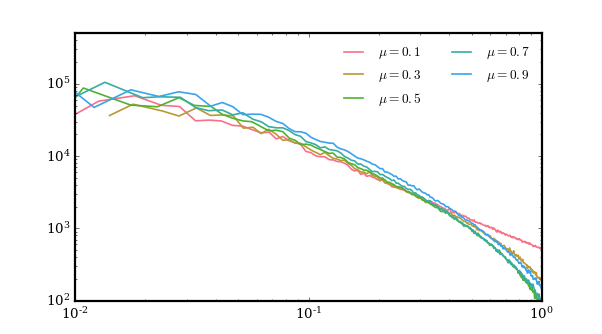

In [24]:
for imu, mu in enumerate(r.power.coords['mu_cen']):
    pk = r.power[:,imu]
    loglog(pk['k'], pk['power'].real - r.attrs['shotnoise'], label = r"$\mu = %.1f$" %(mu))

ax = gca()
ax.set_xlim(1e-2, 1.0); ax.set_ylim(100, 5e5)
ax.legend(ncol=2, loc=0)
show()

# Window-convolved power multipoles from survey data

* update to the Bianchi et al. 2015 and Scoccimarro et al. 2015 papers
* decompose Legendre polynomials into spherical harmonicals
* requires $2 \ell + 1$ FFTs per multipole
* code supports arbitrary $\ell$

$\rightarrow$ typically computes $\ell=[0,2,4]$ in 1-2 minutes on 1 node on NERSC

# Iterating through multiple tasks

hide the MPI communication complexity behind the scenes...

In [ ]:
cosmo = cosmology.Planck15 
CurrentMPIComm.set(comm)

cpus_per_task = 10
with TaskManager(cpus_per_task, use_all_cpus=True) as tm:
    
    # iterate through 3 tasks
    for seed in tm.iterate([0, 1, 2]):

        # uniform particles
        s = Source.UniformParticles(nbar=3e-7, BoxSize=1380., seed=seed)

        # compute P(k,mu) and multipoles
        r = FFTPower(s, mode='2d', Nmesh=8, poles=[0,2,4])

        # and save
        output = "./test_batch_uniform_seed%d.json" % seed
        r.save(output)

# The current state...

## Currently implemented: 

* FOF halo finder
* periodic FFT power: $P(k)$, $P(k,\mu)$, $P_\ell(k)$
* window-convolved multipoles for arbitrary $\ell$
* angular FOF fiber collision assignment

also: synergy with Python-based FastPM `Source`

## works in progress:
* the documentation for version 0.2
* 2-pt correlation function, both pair counting and FFT-based
* multipoles of the isotropic 3 point CF
* bispectrum estimator

very open to contributions or suggestions!

# How to get started?

Nightly builds maintained on Cori and Edison!

Just start your job script with these lines:

```bash
# load new version of nbodykit
module unload python
module load python/3.5-anaconda
source /usr/common/contrib/bccp/nbodykit/activate.sh 0.2

# run your script
srun -n 256 python-mpi compute_qso_power.py
```

And to download the source code:
    
```bash
git clone http://github.com/bccp/nbodykit
cd nbodykit
git checkout v2.0
```

self contained test functions in `nbodykit/tests` that can serve as examples

# Optimization of HOD parameters

![HOD fit](test_fit.pdf)